In [1]:
from pathlib import Path

arches = (
    "linux-64",
    "win-64",
    "osx-64",
    "noarch",
    "linux-ppc64le",
    "linux-aarch64",
    "osx-arm64"
)


def remove_existing(fname):
    if fname.is_file():
        fname.unlink()


# Clean old files first.
path = Path(".")
for arch in arches:
    remove_existing(path.joinpath(f"repodata-{arch}.json"))
    remove_existing(path.joinpath(f"repodata-cf201901-{arch}.json"))

In [2]:
import shutil

import requests


def download_file(url, fname):
    with requests.get(url, stream=True) as r:
        with open(fname, "wb") as f:
            shutil.copyfileobj(r.raw, f)
    return fname

In [3]:
for arch in arches:
    download_file(
        f"https://conda.anaconda.org/conda-forge/{arch}/repodata.json",
        f"repodata-{arch}.json",
    )
    download_file(
        f"https://conda.anaconda.org/conda-forge/label/cf201901/{arch}/repodata.json",
        f"repodata-cf201901-{arch}.json",
    )

In [4]:
import gzip


def read_json(fname):
    with gzip.GzipFile(fname, "r") as f:
        return pd.io.json.loads(f.read())

In [5]:
import glob

import pandas as pd

packages = []
for fname in glob.glob("repodata-*.json"):
    data = read_json(fname)
    df = pd.DataFrame(data["packages"].values())
    df.loc[:, "filename"] = data["packages"].keys()
    packages.append(df)

In [6]:
df = pd.concat(packages, sort=False, ignore_index=True)

In [7]:
df = df.drop_duplicates(subset=["subdir", "filename"])

In [8]:
df.loc[:, "timestamp"] = pd.to_datetime(df.timestamp, unit="ms")

In [9]:
len(df)

553934

In [10]:
df.timestamp.isnull().sum()

97304

In [11]:
has_ts = df[df.timestamp.notnull()]
has_ts.head()

,build,build_number,depends,license,md5,name,noarch,sha256,size,subdir,...,type,app_type,filename,operatingsystem,target-triplet,has_prefix,machine,binstar,requires,features
0,0,0.0,[gcc_linux-64 7.5.*],LicenseRef-OTHER,6f29ba77e8b03b191c9d667f331bf2a0,_current_repodata_hack_gcc_linux_64_75,generic,ecde63af23e0d49c0ece19ec539d873ea408a6f966d312...,3357.0,noarch,...,NaN,NaN,_current_repodata_hack_gcc_linux_64_75-0.0.1-0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0.0,[gcc_linux-64 8.4.*],LicenseRef-OTHER,e7d3afa400b27989a4381d58cfec740a,_current_repodata_hack_gcc_linux_64_84,generic,5fb50ad4ab4615559987b9ec3a9e387de6f26a5ea9f69a...,3351.0,noarch,...,NaN,NaN,_current_repodata_hack_gcc_linux_64_84-0.0.1-0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.0,[gcc_linux-aarch64 7.5.*],LicenseRef-OTHER,a02e93fbfdad3347b95e9ea4f64a2248,_current_repodata_hack_gcc_linux_aarch64_75,generic,ee0c2fbf22dd6353605d6f68df056d6b41ce02bd9adfc1...,3427.0,noarch,...,NaN,NaN,_current_repodata_hack_gcc_linux_aarch64_75-0....,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0.0,[gcc_linux-aarch64 8.4.*],LicenseRef-OTHER,37f4d678daab62eed5cecb188bef4f99,_current_repodata_hack_gcc_linux_aarch64_84,generic,2f635d68a29c0c0ff4f6f57f32265ae2acd5a62fc52188...,3439.0,noarch,...,NaN,NaN,_current_repodata_hack_gcc_linux_aarch64_84-0....,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0.0,[gcc_linux-ppc64le 7.5.*],LicenseRef-OTHER,4ec64f48695247547d4cac078561475e,_current_repodata_hack_gcc_linux_ppc64le_75,generic,fd062eb0b7f3544408cd6180adf6365060adf43d6b4e4b...,3425.0,noarch,...,NaN,NaN,_current_repodata_hack_gcc_linux_ppc64le_75-0....,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
import matplotlib.pyplot as plt

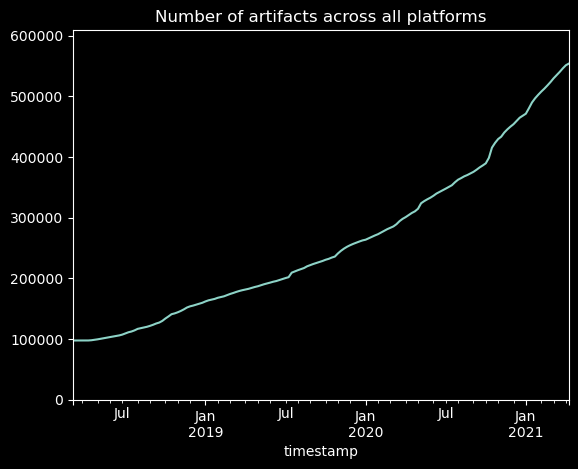

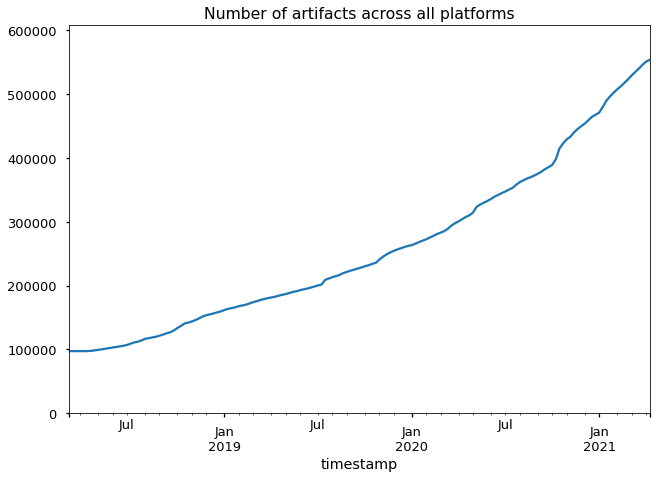

In [13]:
fill_val = "2018-03-01"
df_has = (
    df.fillna(pd.to_datetime(fill_val)).sort_values("timestamp").set_index("timestamp")
)
df_has.loc[:, "package_count"] = list(range(1, len(df_has) + 1))
df_arrival = df_has.groupby(df_has.index.to_period("W")).package_count.max()
for context in [("dark_background", "seaborn-talk"), ("seaborn-talk", )]:
    with plt.style.context(*context):
        fig, ax = plt.subplots()
        df_arrival[df_arrival.index > fill_val].plot(
            title="Number of artifacts across all platforms",
            ylim=(0, df_arrival.max() * 1.1),
            ax=ax
    #         figsize=(16, 9),
        )
        fig.savefig(f"plots/n_artifacts-{'_'.join(context)}.png", bbox_inches='tight', transparent=True)

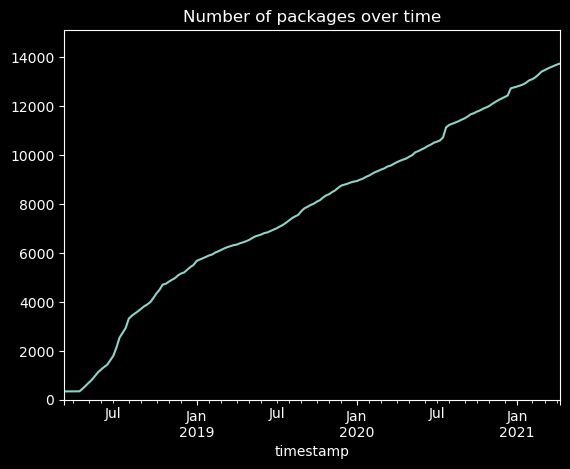

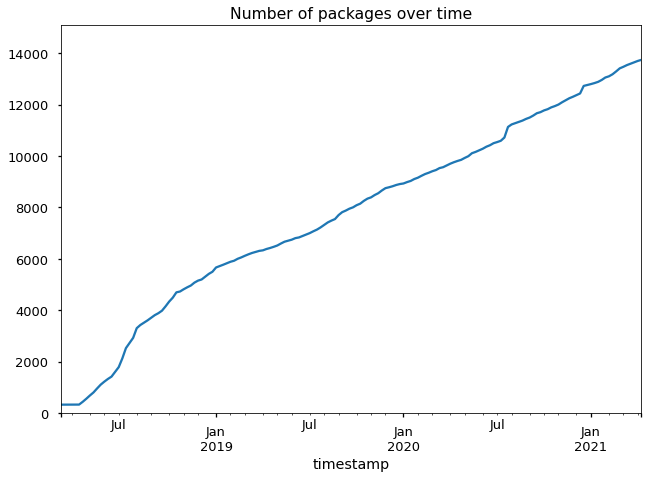

In [14]:
fill_val = "2018-03-01"
x = (
    df.sort_values("timestamp")
    .fillna(pd.to_datetime(fill_val))
    .groupby(df.name)
    .first()
)
first_date = pd.DataFrame(x.timestamp).reset_index().set_index("timestamp").sort_index()
first_date.loc[:, "package_count"] = list(range(1, len(first_date) + 1))
df_first = first_date.groupby(first_date.index.to_period("W")).package_count.max()
for context in [("dark_background", "seaborn-talk"), ("seaborn-talk", )]:
    with plt.style.context(*context):
        fig, ax = plt.subplots()
        df_first[df_first.index > fill_val].plot(
            title="Number of packages over time",
            ylim=(0, df_first.max() * 1.1),
            ax=ax
#             figsize=(16, 9),
        )
        fig.savefig(f"plots/n_feedstocks-{'_'.join(context)}.png", bbox_inches='tight', transparent=True)

In [15]:
ddf = df_first[df_first.index > fill_val]

In [16]:
ddf.index.to_numpy()[40], ddf.index.to_numpy()[92]

(Period('2019-01-07/2019-01-13', 'W-SUN'),
 Period('2020-01-06/2020-01-12', 'W-SUN'))

In [17]:
print(ddf.index.to_numpy()[40], ddf.index.to_numpy()[92], ddf.to_numpy()[92] - ddf.to_numpy()[40])

2019-01-07/2019-01-13 2020-01-06/2020-01-12 3268


In [18]:
print(ddf.index.to_numpy()[92], ddf.index.to_numpy()[-1], ddf.to_numpy()[-1] - ddf.to_numpy()[92])

2020-01-06/2020-01-12 2021-04-05/2021-04-11 4752


In [19]:
arch_df = {}
for arch in arches:
    fill_val = "2018-03-01"
    x = (
        df.sort_values("timestamp")
        .fillna(pd.to_datetime(fill_val))
        .loc[df.subdir == arch]
        .groupby(df.name)
        .first()
    )
    first_date = (
        pd.DataFrame(x.timestamp).reset_index().set_index("timestamp").sort_index()
    )
    first_date.loc[:, "package_count"] = list(range(1, len(first_date) + 1))
    df_first = first_date.groupby(first_date.index.to_period("W")).package_count.max()
    arch_df[arch] = df_first

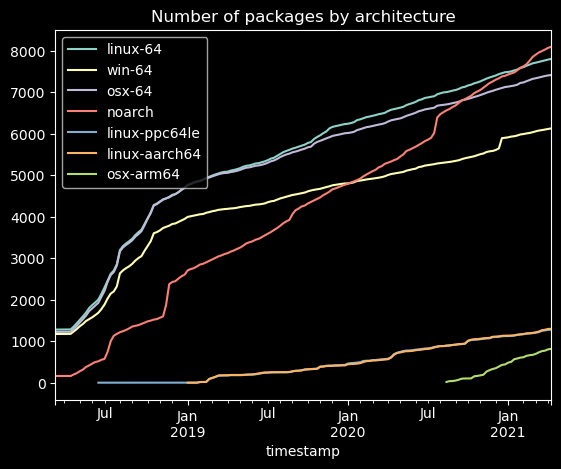

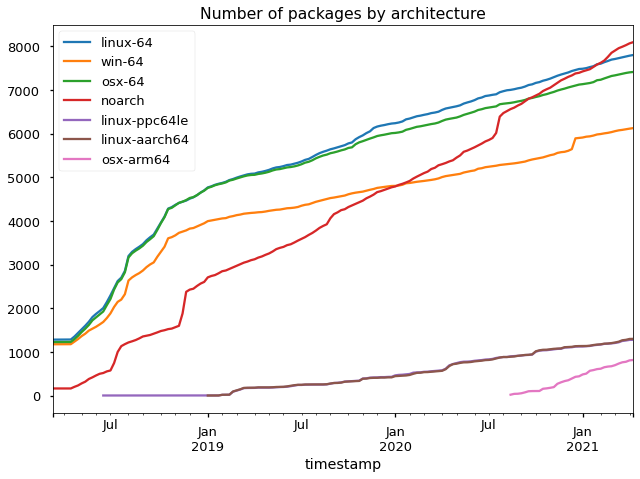

In [20]:
import matplotlib.pyplot as plt

for context in [("dark_background", "seaborn-talk"), ("seaborn-talk", )]:
    with plt.style.context(*context):
        fig, ax = plt.subplots()
        plot_df = pd.DataFrame(arch_df)
        plot_df.ffill()[plot_df.index > fill_val].plot(
            title="Number of packages by architecture",
            ax=ax
        )
        fig.savefig(f"plots/n_feedstocks_by_arch-{'_'.join(context)}.png", bbox_inches='tight', transparent=True)

In [21]:
arch_df

{'linux-64': timestamp
 2017-09-18/2017-09-24       1
 2018-02-26/2018-03-04    1277
 2018-03-05/2018-03-11    1282
 2018-04-09/2018-04-15    1285
 2018-04-16/2018-04-22    1353
                          ... 
 2021-03-08/2021-03-14    7729
 2021-03-15/2021-03-21    7748
 2021-03-22/2021-03-28    7768
 2021-03-29/2021-04-04    7785
 2021-04-05/2021-04-11    7800
 Freq: W-SUN, Name: package_count, Length: 160, dtype: int64,
 'win-64': timestamp
 2017-10-16/2017-10-22       1
 2018-01-15/2018-01-21       2
 2018-02-26/2018-03-04    1176
 2018-04-09/2018-04-15    1178
 2018-04-16/2018-04-22    1235
                          ... 
 2021-03-08/2021-03-14    6075
 2021-03-15/2021-03-21    6086
 2021-03-22/2021-03-28    6101
 2021-03-29/2021-04-04    6114
 2021-04-05/2021-04-11    6126
 Freq: W-SUN, Name: package_count, Length: 160, dtype: int64,
 'osx-64': timestamp
 2017-08-07/2017-08-13       1
 2017-09-11/2017-09-17      11
 2018-02-26/2018-03-04    1225
 2018-03-05/2018-03-11    1226
 2018

In [22]:
df.tail()

,build,build_number,depends,license,md5,name,noarch,sha256,size,subdir,...,type,app_type,filename,operatingsystem,target-triplet,has_prefix,machine,binstar,requires,features
705337,np111py35_5,5.0,"[cycler, freetype 2.6.*, libpng >=1.6.21,<1.7,...",PSF-based (http://matplotlib.org/users/license...,a4b57ef449d0532b380b1541018ac3f1,matplotlib,NaN,NaN,4267263.0,osx-64,...,NaN,NaN,matplotlib-1.5.2-np111py35_5.tar.bz2,darwin,x86_64-any-darwin,True,x86_64,"{'package_id': '55f96af4d3234d09d1951089', 'ch...",[],NaN
705339,py37hfc77a4a_11,11.0,"[libgdal 2.2.4 hb773750_11, numpy >=1.9.3,<2.0...",MIT,3c509ee6198ed6bb243fc2348c46bc42,gdal,NaN,NaN,1214777.0,osx-64,...,NaN,NaN,gdal-2.2.4-py37hfc77a4a_11.tar.bz2,darwin,x86_64-any-darwin,False,x86_64,"{'package_id': '56defd5d266fe421112d4327', 'ch...",[],NaN
705373,np112py35_0,0.0,"[cycler >=0.10, freetype 2.7|2.7.*, libpng >=1...",PSF-based,c5bd071ce6840ba90677a3db04c3f9ba,matplotlib,NaN,NaN,6948234.0,osx-64,...,NaN,NaN,matplotlib-2.0.2-np112py35_0.tar.bz2,darwin,x86_64-any-darwin,False,x86_64,"{'package_id': '55f96af4d3234d09d1951089', 'ch...",[],NaN
705420,np19py35_1,1.0,"[geos >=3.4.2, matplotlib, numpy 1.9*, pyproj,...",MIT,a0a684579b73f3f6f0aee329db84e332,basemap,NaN,NaN,16314886.0,osx-64,...,NaN,NaN,basemap-1.0.8.dev0-np19py35_1.tar.bz2,darwin,x86_64-any-darwin,NaN,x86_64,"{'package_id': '56f68e504733c34f5eddbd86', 'ch...",[],NaN
705450,py37h54a03ab_0,0.0,"[affine >=1.3.0, attrs >=16.0.0, boto3 >=1.2.4...",BSD 3-Clause,f1c30fc2acf84b7eaf74e04b5a1ba768,rasterio,NaN,NaN,8365407.0,osx-64,...,NaN,NaN,rasterio-1.0.13-py37h54a03ab_0.tar.bz2,darwin,x86_64-any-darwin,False,x86_64,"{'package_id': '56faba7f0697b60a623ee585', 'ch...",[],NaN
